#**Inference of toxicity scores of CrowdTangle (Hindi + English) dataset by using Perspective API**


For details on Google's Perspective API, see the [`get started documentation`](https://support.perspectiveapi.com/s/docs-get-started) and also the [`full documentation`](https://developers.perspectiveapi.com/s/about-the-api).





##**Installs and imports**
---

### Installation of the Google API Python client library


In [1]:
!pip3 install google-api-python-client flatdict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for flatdict: filename=flatdict-4.0.1-py3-none-any.whl size=6946 sha256=cd699fdc0461e6ec4a80fb653132f25f0a2ca2e71e79bbe5fa2a2a798238b8ac
  Stored in directory: /root/.cache/pip/wheels/45/8e/ad/5b3f88ff913fa6563c5eb2c84cc0cd78ca223548ff913ca822
Successfully built flatdict


### Import `discovery` module and other necessary modules


In [89]:
from googleapiclient import discovery
import json
import flatdict
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

Declare the API key

In [25]:
API_KEY = 'XYZXYZXYZXYZXYZXYZXYZXYZ'

##**Load and pre-process the CrowdTangle dataset for inference**
---

### Mount the drive and load the CrowdTangle CSV as a dataframe

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [100]:
CT_data = pd.read_csv ('/content/drive/My Drive/datasets/CT_dataset.csv', low_memory=False,  lineterminator='\n', sep=';', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [101]:
CT_data.shape

(604703, 40)

Because the size of the dataset is too large, let's choose first N values from the dataframe for a proof-of-concept (PoC) run

In [102]:
CT_data = CT_data.head(5000)

In [103]:
CT_data.shape

(5000, 40)

In [104]:
CT_data.columns

Index(['account.name', 'account.handle', 'platformId', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'subscriberCount', 'Followers at Posting', 'date', 'Post Created Date',
       'Post Created Time', 'type', 'totalInteraction',
       'statistics.actual.likeCount', 'statistics.actual.commentCount',
       'statistics.actual.shareCount', 'statistics.actual.loveCount',
       'statistics.actual.wowCount', 'statistics.actual.hahaCount',
       'statistics.actual.sadCount', 'statistics.actual.angryCount',
       'statistics.actual.careCount', 'Video Share Status', 'Is Video Owner?',
       'statistics.actual.videoPostViewCount',
       'statistics.actual.videoTotalViewCount',
       'statistics.actual.videoAllCrosspostsViewCount', 'Video Length',
       'postUrl', 'message', 'expandedLinks.original',
       'expandedLinks.expanded', 'imageText', 'title', 'description',
       'brandedContentSponsor.platformId', 'brandedContentSponsor.name',
 

### Preprocess the dataset for toxicity prediction task

In [107]:
#replace NaN values in particular columns with empty string
CT_data.message = CT_data.message.fillna('')
CT_data.description = CT_data.description.fillna('')
CT_data.imageText = CT_data.imageText.fillna('')

In [108]:
# extract different column entries
message_df = CT_data ['message']
description_df = CT_data['description']
imageText_df = CT_data['imageText']

print ("Total number of entries in the message dataset:", len(message_df))
message_df.tail()

Total number of entries in the message dataset: 5000


4995    फार्ट चेकर जुबैर की बढ़ी मुश्किलें, 2 और मुकदम...
4996                         जय श्रीराम BJP Uttar Pradesh
4997    आज उदयपुर में #kanahiyalal जी के परिवार के मिल...
4998                                                 none
4999                                                 none
Name: message, dtype: object

In [109]:
description_df.head()

0                                                 none
1    बॉलीवुड के मशहूर अभिनेता अनिल कपूर एक ऐसे अभिन...
2    बॉलीवुड के मशहूर अभिनेता अनिल कपूर एक ऐसे अभिन...
3    पेट्रोलियम कंपनियों ने रोज की तरह आज सुबह 6 बज...
4    पेट्रोलियम कंपनियों ने रोज की तरह आज सुबह 6 बज...
Name: description, dtype: object

In [110]:
imageText_df.tail()

4995                                                 none
4996                                                 none
4997                                                 none
4998    Ashok Shrivastav @AshokShrivasta6 कपिल जी ने #...
4999                                                 none
Name: imageText, dtype: object

In [111]:
# convert dataframes to list
message_list = message_df.tolist()
description_list = description_df.tolist()
imageText_list = imageText_df.tolist()

##**Define necessary functions to retrieve the `CommentAnalyzer` responses**
---

### Define a `discovery` client


To inspect further details about the module `discovery`, see [here](https://googleapis.github.io/google-api-python-client/docs/epy/googleapiclient.discovery-module.html).

In [112]:
client = discovery.build (
  serviceName = "commentanalyzer",
  version = "v1alpha1",
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  developerKey=API_KEY
)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

### Define `AnalyzeComment` request to the Perspective API and retrieve the response


For more details on the `Attributes` and `Languages`, see [here](https://developers.perspectiveapi.com/s/about-the-api-attributes-and-languages).

In [113]:
def analyzer (TEXT: str):
  analyze_input = {
  "comment": { 
      "text": TEXT,
      "type": 'PLAIN_TEXT'
  },
  'requestedAttributes': {
      'TOXICITY': {}
  },
  'spanAnnotations': False,
  "doNotStore": False,
  "languages": ["en", "hi"]
  }
  return analyze_input

Retrieve the response of the request

In [114]:
def get_response (analyzer_input):
  response = client.comments().analyze(body=analyzer_input).execute()
  return response

## **Running inference task over the CrowdTangle dataset**
---

### Define function that returns the forward score of the toxicity prediction task for a given list input

In [115]:
def forward (TEXT_LIST):
  score = [0] * len(TEXT_LIST)

  for i in range (len(TEXT_LIST)):
    if i % 50 == 0:
      print('Batch ', i+1,' of ',len(TEXT_LIST))

    if TEXT_LIST [i] != '':
      analyze_request = analyzer (TEXT_LIST[i])
      response = get_response (analyze_request)

      score [i] = float(response['attributeScores']['TOXICITY']['summaryScore']['value'])
  
  return score 

### Running the forward function through the `message` list

In [116]:
message_score_list = forward(message_list)

Batch  1  of  5000
Batch  51  of  5000
Batch  101  of  5000
Batch  151  of  5000
Batch  201  of  5000
Batch  251  of  5000
Batch  301  of  5000
Batch  351  of  5000
Batch  401  of  5000
Batch  451  of  5000
Batch  501  of  5000
Batch  551  of  5000
Batch  601  of  5000
Batch  651  of  5000
Batch  701  of  5000
Batch  751  of  5000
Batch  801  of  5000
Batch  851  of  5000
Batch  901  of  5000
Batch  951  of  5000
Batch  1001  of  5000
Batch  1051  of  5000
Batch  1101  of  5000
Batch  1151  of  5000
Batch  1201  of  5000
Batch  1251  of  5000
Batch  1301  of  5000
Batch  1351  of  5000
Batch  1401  of  5000
Batch  1451  of  5000
Batch  1501  of  5000
Batch  1551  of  5000
Batch  1601  of  5000
Batch  1651  of  5000
Batch  1701  of  5000
Batch  1751  of  5000
Batch  1801  of  5000
Batch  1851  of  5000
Batch  1901  of  5000
Batch  1951  of  5000
Batch  2001  of  5000
Batch  2051  of  5000
Batch  2101  of  5000
Batch  2151  of  5000
Batch  2201  of  5000
Batch  2251  of  5000
Batch  2301

### Appending the scores to the pandas dataframe

In [117]:
CT_data ['messageToxicity.score'] = message_score_list

In [118]:
CT_data.head()

,account.name,account.handle,platformId,Page Category,Page Admin Top Country,Page Description,Page Created,subscriberCount,Followers at Posting,date,...,expandedLinks.original,expandedLinks.expanded,imageText,title,description,brandedContentSponsor.platformId,brandedContentSponsor.name,brandedContentSponsor.category,score,messageToxicity.score
0,Bajrangi Dal,BajrangDalKolkata,354861651263021,RELIGIOUS_ORGANIZATION,IN,अपने और अपनोँ के सुरक्षित भविष्य हेतु बँगाली ...,2012-09-12 10:38:05,35222.0,41363.0,2022-07-11 13:08:35 CEST,...,https://www.facebook.com/BajrangDalKolkata/vid...,NaN,none,NaN,none,NaN,NaN,NaN,-2.82,0.007011
1,True Nationalist,TrueNationalistOfficial,623564924746688,LOCAL,IN,हिन्दू धर्म से संबंधित वीडियो के लिए हमारे पेज...,2019-03-09 08:12:47,275031.0,555551.0,2022-07-11 12:41:07 CEST,...,https://appearnews.com/anil-kapoor-has-become-...,NaN,none,अनिल कपूर गुंजी बच्चे की किलकारियां बन गए नाना...,बॉलीवुड के मशहूर अभिनेता अनिल कपूर एक ऐसे अभिन...,NaN,NaN,NaN,-0.64,0.392301
2,Pushpendra Kulshrestha Fans Club,Pushpendrarss,313739616231431,ACTIVITY_GENERAL,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2019-06-07 08:59:33,445145.0,848530.0,2022-07-11 12:38:52 CEST,...,https://appearnews.com/anil-kapoor-has-become-...,NaN,none,अनिल कपूर गुंजी बच्चे की किलकारियां बन गए नाना...,बॉलीवुड के मशहूर अभिनेता अनिल कपूर एक ऐसे अभिन...,NaN,NaN,NaN,1.37,0.392301
3,True Nationalist,TrueNationalistOfficial,623564924746688,LOCAL,IN,हिन्दू धर्म से संबंधित वीडियो के लिए हमारे पेज...,2019-03-09 08:12:47,275063.0,555595.0,2022-07-11 12:09:08 CEST,...,https://appearnews.com/there-is-good-news-abou...,NaN,none,पट्रोल-डीजल को लेकर आई खुशखबरी मिल रहा है मात्...,पेट्रोलियम कंपनियों ने रोज की तरह आज सुबह 6 बज...,NaN,NaN,NaN,-0.71,0.026207
4,Pushpendra Kulshrestha Fans Club,Pushpendrarss,313739616231431,ACTIVITY_GENERAL,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2019-06-07 08:59:33,445145.0,848530.0,2022-07-11 12:06:36 CEST,...,https://appearnews.com/there-is-good-news-abou...,NaN,none,पट्रोल-डीजल को लेकर आई खुशखबरी मिल रहा है मात्...,पेट्रोलियम कंपनियों ने रोज की तरह आज सुबह 6 बज...,NaN,NaN,NaN,1.53,0.026207


### Vizualisations of the scores and their correlations with actors & page categories

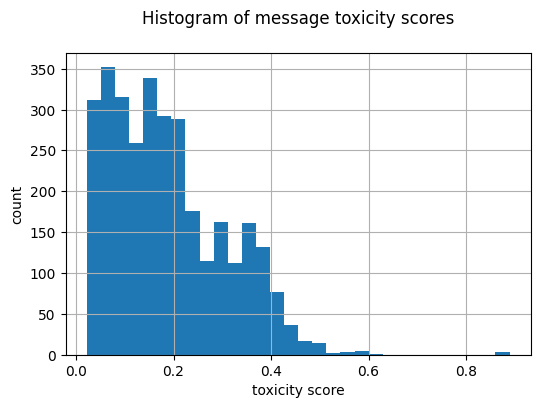

In [146]:
plt.figure(figsize=(6,4),dpi=100)
#plt.hist(CT_data['messageToxicity.score'], bins=30, range=[0.022, 1.0], align='mid')
non_zero = CT_data [CT_data['messageToxicity.score'] > 0.022]
non_zero['messageToxicity.score'].hist(bins=30)
plt.title('Histogram of message toxicity scores\n')
plt.ylabel('count')
plt.xlabel('toxicity score')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2346 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2369 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2359 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2306 missing from current font.
  font.set_text(s

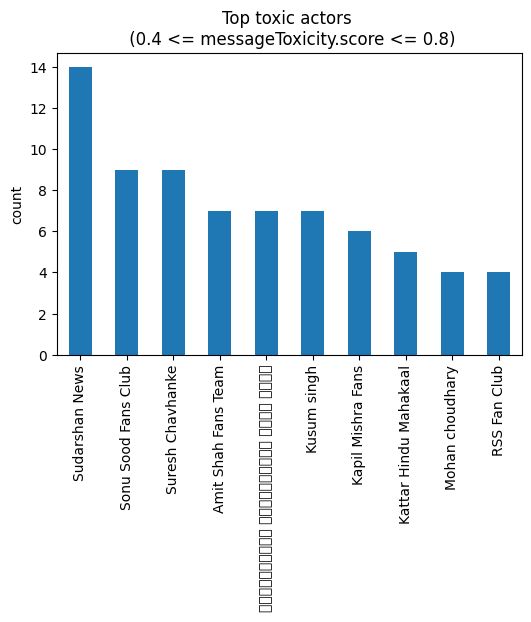

In [158]:
plt.figure(figsize=(6,4),dpi=100)

mid_toxic = CT_data [ (CT_data['messageToxicity.score'] >= 0.4) & (CT_data['messageToxicity.score'] <= 0.8)]
mid_toxic['account.name'].value_counts()[:10].plot(kind='bar')

plt.title('Top toxic actors \n (0.4 <= messageToxicity.score <= 0.8)')
plt.ylabel('count')

plt.show()

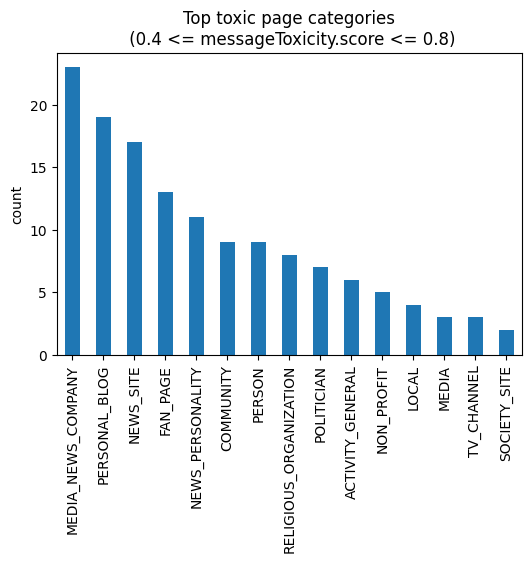

In [159]:
plt.figure(figsize=(6,4),dpi=100)

#mid_toxic = CT_data [ (CT_data['messageToxicity.score'] >= 0.4) & (CT_data['messageToxicity.score'] <= 0.8)]
mid_toxic['Page Category'].value_counts()[:15].plot(kind='bar')

plt.title('Top toxic page categories\n (0.4 <= messageToxicity.score <= 0.8)')
plt.ylabel('count')

plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2346 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2369 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2359 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s

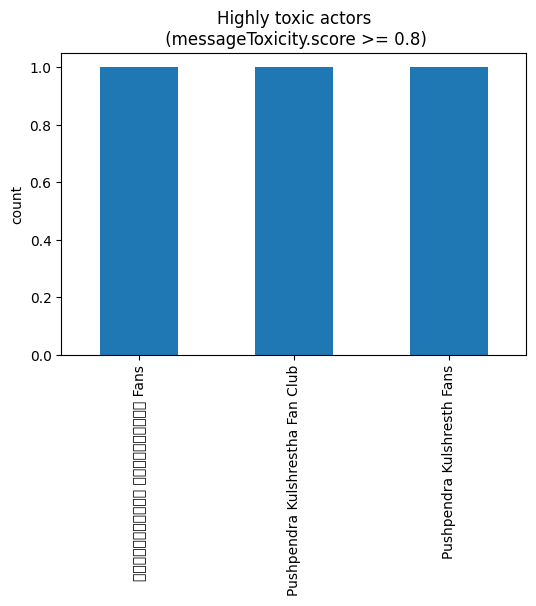

In [160]:
plt.figure(figsize=(6,4),dpi=100)

high_toxic = CT_data [CT_data['messageToxicity.score'] >= 0.8]
high_toxic ['account.name'].value_counts()[:10].plot(kind='bar')

plt.title('Highly toxic actors\n (messageToxicity.score >= 0.8)')
plt.ylabel('count')

plt.show()

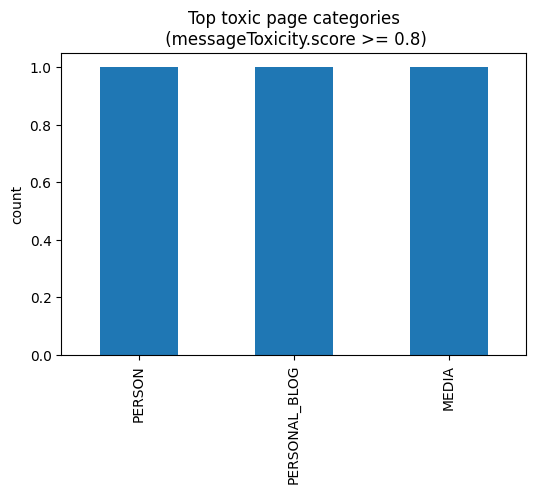

In [161]:
plt.figure(figsize=(6,4),dpi=100)


high_toxic['Page Category'].value_counts()[:15].plot(kind='bar')

plt.title('Top toxic page categories\n (messageToxicity.score >= 0.8)')
plt.ylabel('count')

plt.show()